# Homework 4

## FINM 37500: Fixed Income Derivatives

### Mark Hendricks

#### Winter 2025

***

### Data

The file `data/ratetree_data_2025-01-31.xlsx` has a binomial tree of interest rates fit to...
* discount curves from `cap_curves_2025-01-31.xlsx`
* implied vols from `cap_curves_2025-01-31.xlsx`

Note the following...
* Suppose the present date is `2025-01-31`.
* The rates are continuously compounded.
* The rates are for the following quarter. So teh rate at $t=0$ is the continuously compounded rate for the interval $t=0$ to $t=.25$.

Take this binomial tree as given; there is no need to fit it yourself.

In [7]:
import pandas as pd

DATE = '2025-01-31'
FILEIN = f'../../data/ratetree_data_{DATE}.xlsx'
sheet_tree = 'rate tree'

ratetree = pd.read_excel(FILEIN, sheet_name=sheet_tree).set_index('state')
ratetree.columns.name = 'time'

ratetree.style.format('{:.1%}',na_rep='').format_index('{:.2f}',axis=1)

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75
state,,,,,,,,,,,,,,,,,,,,
0,4.2%,4.3%,4.4%,4.8%,5.1%,6.4%,7.6%,9.1%,10.1%,11.8%,13.5%,15.3%,16.9%,19.2%,22.7%,25.9%,28.2%,30.6%,34.7%,40.3%
1,,3.9%,4.0%,4.2%,4.4%,5.2%,6.0%,7.0%,7.8%,9.0%,10.4%,11.8%,13.0%,14.8%,17.4%,19.9%,21.7%,23.7%,27.0%,31.2%
2,,,3.6%,3.7%,3.8%,4.2%,4.7%,5.4%,6.0%,7.0%,8.0%,9.1%,10.1%,11.4%,13.4%,15.3%,16.7%,18.4%,20.9%,24.2%
3,,,,3.3%,3.2%,3.3%,3.7%,4.2%,4.6%,5.3%,6.2%,7.0%,7.8%,8.8%,10.3%,11.8%,12.9%,14.2%,16.3%,18.8%
4,,,,,2.8%,2.7%,2.9%,3.3%,3.6%,4.1%,4.7%,5.4%,6.0%,6.8%,7.9%,9.1%,10.0%,11.0%,12.6%,14.6%
5,,,,,,2.2%,2.3%,2.5%,2.7%,3.2%,3.6%,4.2%,4.6%,5.2%,6.1%,7.0%,7.7%,8.6%,9.8%,11.3%
6,,,,,,,1.8%,2.0%,2.1%,2.4%,2.8%,3.2%,3.6%,4.0%,4.7%,5.4%,5.9%,6.6%,7.6%,8.8%
7,,,,,,,,1.5%,1.6%,1.9%,2.2%,2.5%,2.7%,3.1%,3.6%,4.1%,4.6%,5.1%,5.9%,6.8%
8,,,,,,,,,1.3%,1.4%,1.7%,1.9%,2.1%,2.4%,2.8%,3.2%,3.5%,4.0%,4.6%,5.3%


***

# 1. Binomial Tree Pricing - Bond

### The Bond

Consider a vanilla (non-callable) bond with the following parameters...
* `T=5`
* coupon rate is `4.41%`
* coupons are semiannual

Note that this is essentially the hypothetical bond priced in HW 1.

### 1.1

Create and display a tree of cashflows from the bond, corresponding to each node of the tree (state and time) seen in the interest rate tree.

Note that the cashflows do not depend on the interest rates. Thus, report the cashflows at the time (in the column) they are actually paid out. The final payoff (face plus coupon) occurs at $T$, which is beyond the interest rate tree. You are welcome to add a column for $T$ or to consider this payoff separately and leave it out of the tree.

In [8]:
import sys
sys.path.insert(0, '../../cmds')
from ficcvol import *
from binomial import *
from ratecurves import *

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [9]:
T = 5
freq = 2
cpn = 0.0441

In [10]:
cftree = construct_bond_cftree(T, 4, cpn)

<Axes: xlabel='time', ylabel='state'>

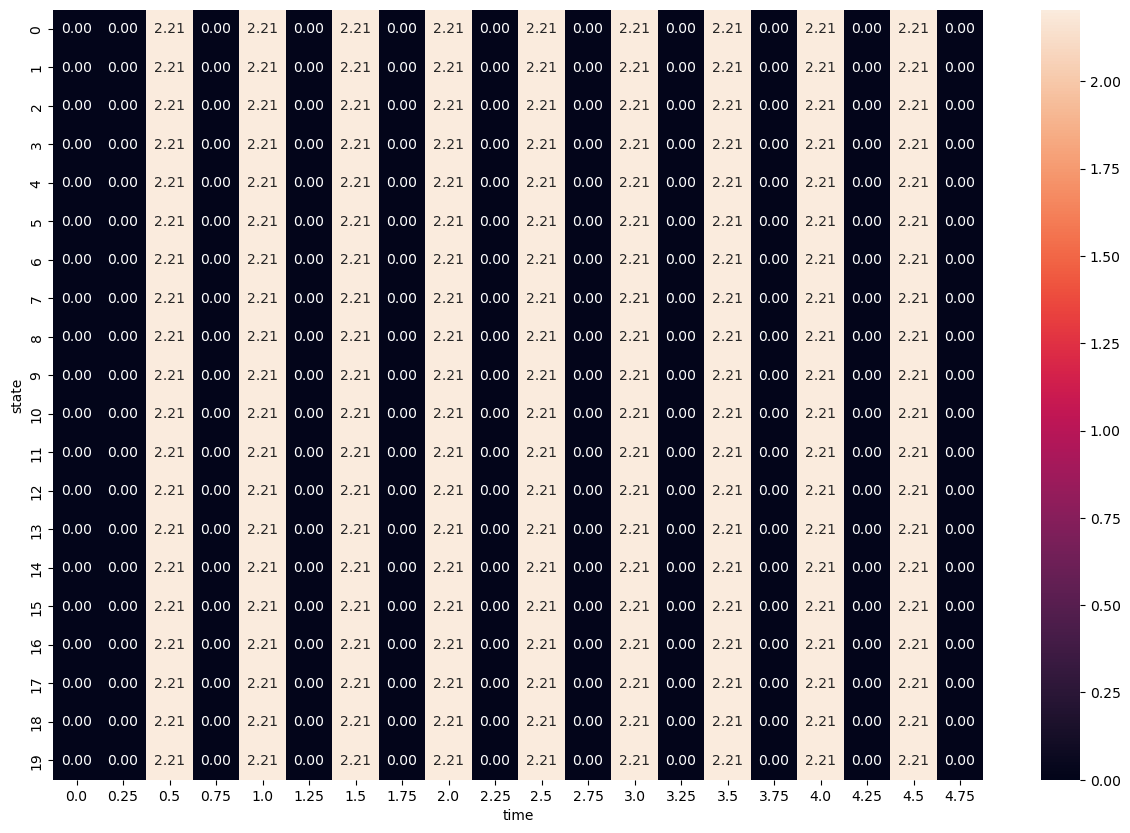

In [11]:
plt.figure(figsize=(15, 10))
sns.heatmap(cftree, annot=True, fmt='.2f')

### 1.2.

Create and display a tree of values of the bond. Do this for the quotes as
* clean quotes
* dirty quotes

Given the semiannual coupons and quarterly tree steps, the clean and dirty will coincide at $t=0, .5, 1,...$.

Do the valuation by...
* setting the value at $T$ as the face plus final coupon.
* discounting this back through time, using the (continuously-compounded) interest rate.
* recall that the tree is constructed such that the probability of moving "up" or "down" is 50%.

In [12]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

dt = 1/4
tsteps = int(T/dt)
wrapper_bond = lambda r: payoff_bond(r, dt, facevalue=100 * (1+cpn/2))

bondtree = bintree_pricing(payoff=wrapper_bond, ratetree=ratetree.iloc[:tsteps,:tsteps], cftree=cftree)

<Axes: title={'center': 'Bond Price Tree - Dirty Price'}, xlabel='time', ylabel='state'>

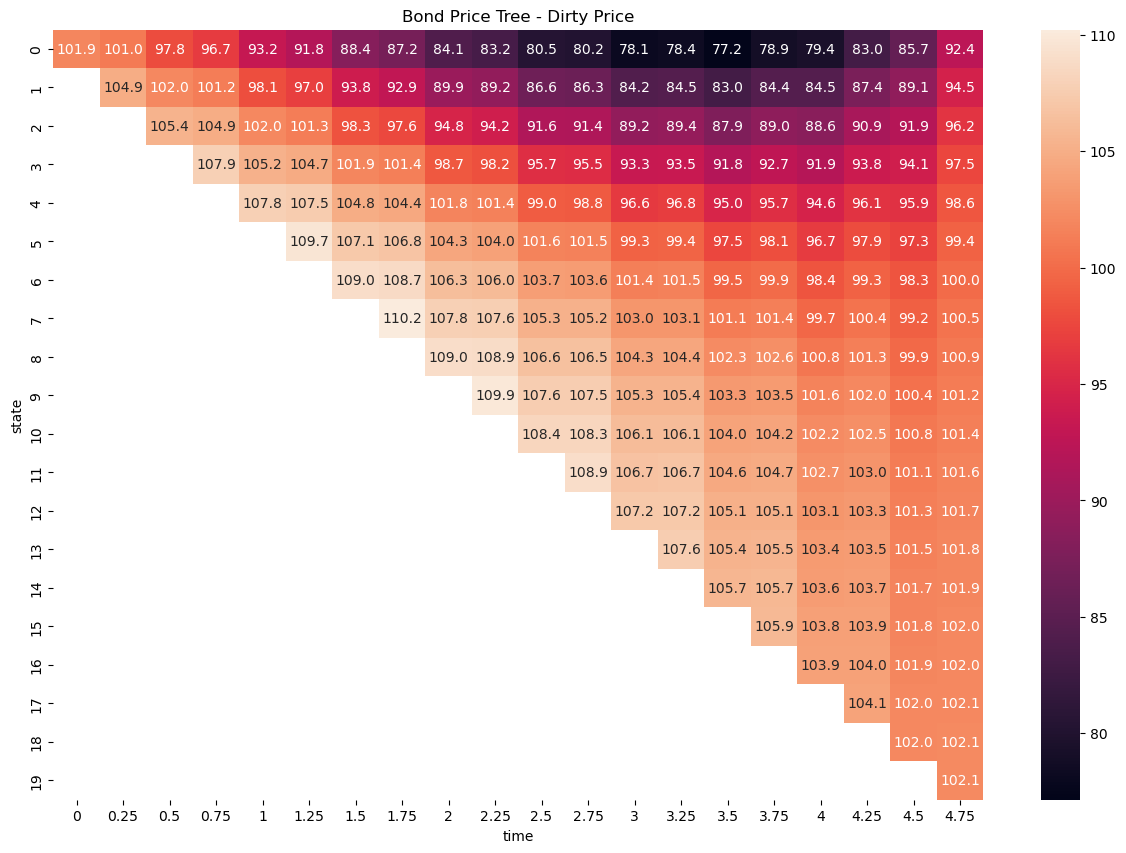

In [13]:
plt.figure(figsize=(15, 10))
plt.title('Bond Price Tree - Dirty Price')
sns.heatmap(bondtree, annot=True, fmt='.1f')

In [14]:
compound = 4
accint = construct_accint(bondtree.columns.values, compound, cpn)
cleantree = np.maximum(bondtree.subtract(accint,axis=1),0)

<Axes: title={'center': 'Bond Price Tree - Clean Price'}, xlabel='time', ylabel='state'>

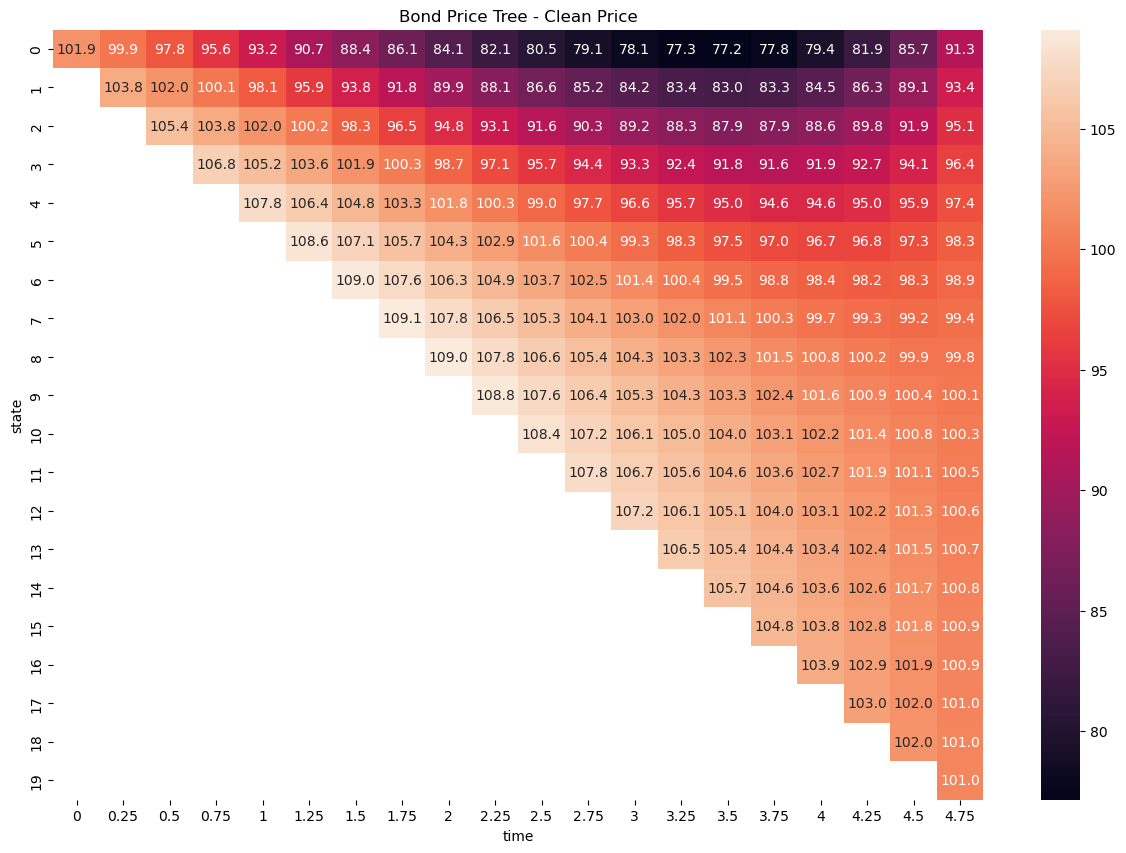

In [15]:
plt.figure(figsize=(15, 10))
plt.title('Bond Price Tree - Clean Price')
sns.heatmap(cleantree, annot=True, fmt='.1f')

### 1.3.

The binomial-estimated price of the bond is the initial node of the value tree.

Report this along with the price of the bond you would get from the usual simple formula for such a bond. 
* Consider pricing it with the $T$ interval swap rate (used similar to a ytm) from the file `cap_curves_2025-01-31.xlsx`.
* If you do this, recall that the swap rate given in that file is quarterly-compounded, so you would need to convert it to semiannual compounding before plugging it into the usual closed-form ytm-pricing formula.

In [16]:
def price_bond_textbook(ytm, T, cpn, cpnfreq=2, face=100, accr_frac=None):
    ytm_n = ytm/cpnfreq
    cpn_n = cpn/cpnfreq
    
    if accr_frac is None:
        #accr_frac = 1 - (T-round(T))*cpnfreq        
        accr_frac = 0

    if cpn==0:
        accr_frac = 0
        
    N = T * cpnfreq
    price = face * ((cpn_n / ytm_n) * (1-(1+ytm_n)**(-N)) + (1+ytm_n)**(-N)) * (1+ytm_n)**(accr_frac)
    return price
path = "../../data/cap_curves_2025-01-31.xlsx"
cap_curves = pd.read_excel(path).set_index('tenor')

ytm_quarterly = cap_curves.loc[T,"swap rates"]
ytm_semianual = ((1+ytm_quarterly/4)**2 - 1)*2
price_calculated = price_bond_textbook(ytm_semianual, T, cpn, cpnfreq=2, face=100)

In [17]:
pd.DataFrame([bondtree.iloc[0,0], cleantree.iloc[0,0], price_calculated], index=['Dirty Price', 'Clean Price', 'Calculated Price'], columns=['Price']).style.format('{:.2f}')

,Price
Dirty Price,101.87
Clean Price,101.87
Calculated Price,101.87


### Note:

An easy check on your code is whether it will correctly price a zero-coupon bond at a price that matches the "discounts" in the `cap_curves` data file.

***

# 2. Pricing the Callable - European

### 2.1.

Calculate and display value tree of a European-style call option on the bond analyzed in part `1`.
* `$T_o = 3$`. That is, the time-to-expiration is 3 years.
* `$K=100$`. That is, the strike is 100. This is a clean strike, meaning exercise requires paying the strike plus any accrued interest.

Do so by 
* setting the value at the time of expiration, using the value of the bond for each node at that time.
* discounting this back through time, using the (continuously-compounded) interest rate.
* recall that the tree is constructed such that the probability of moving "up" or "down" is 50%.

Note that...
* the tree of call values will not be the same size as the tree of bond values. The former goes only to $T_o=3$.

In [18]:
T0 = 3
STRIKE = 100 
payoff_call = lambda p: np.maximum(p-STRIKE,0)

In [19]:
calltree = bintree_pricing(payoff=payoff_call, ratetree=ratetree.iloc[:13,:13], undertree= cleantree.iloc[:13,:13], style='european')

<Axes: title={'center': 'Call Option Price Tree'}, xlabel='time', ylabel='state'>

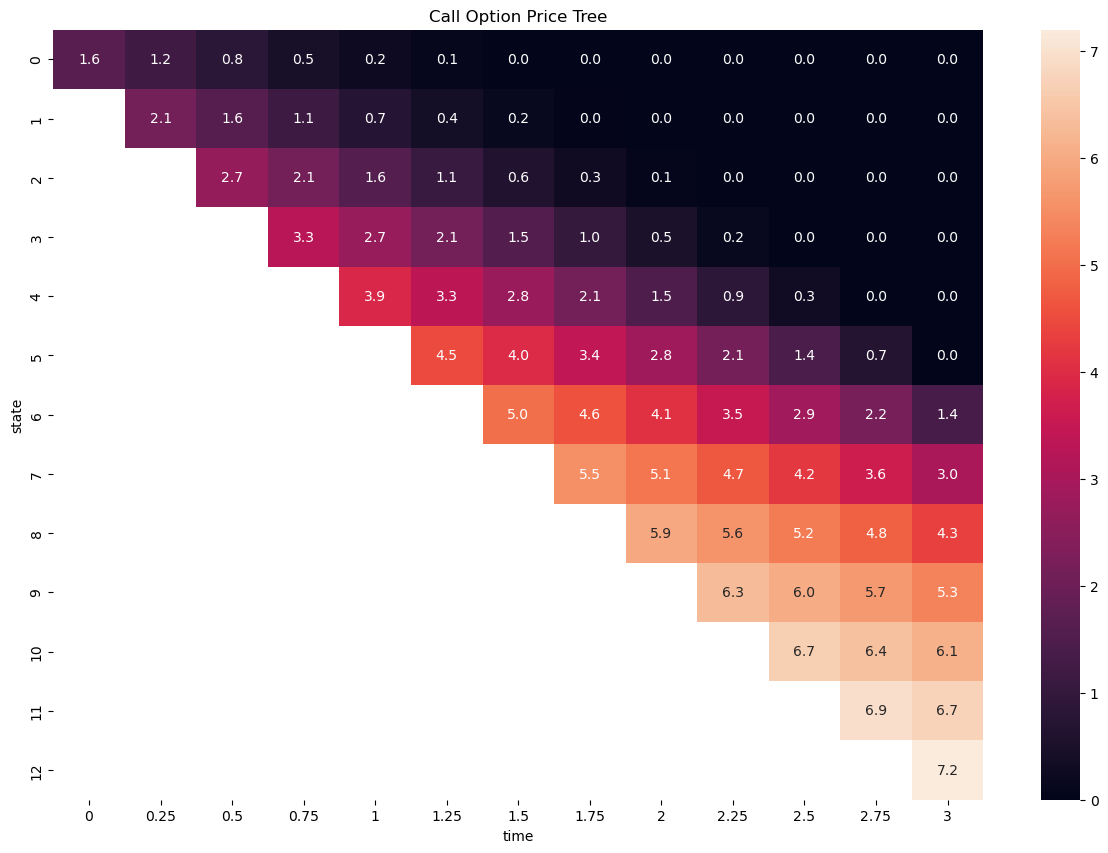

In [20]:
plt.figure(figsize=(15, 10))
plt.title('Call Option Price Tree')
sns.heatmap(calltree, annot=True, fmt='.1f')

### 2.2.

Show the value tree of the callable bond by subtracting the call value tree from the (subset $t\le T_o$ of the) bond value tree (calculated in part `1`.) Do this for both
* clean
* dirty

In [21]:
callablebondtree_clean = cleantree.iloc[:13,:13] - calltree
callablebondtree_dirty = bondtree.iloc[:13,:13] - calltree

<Axes: title={'center': 'Callable Bond Price Tree - Clean Price'}, xlabel='time', ylabel='state'>

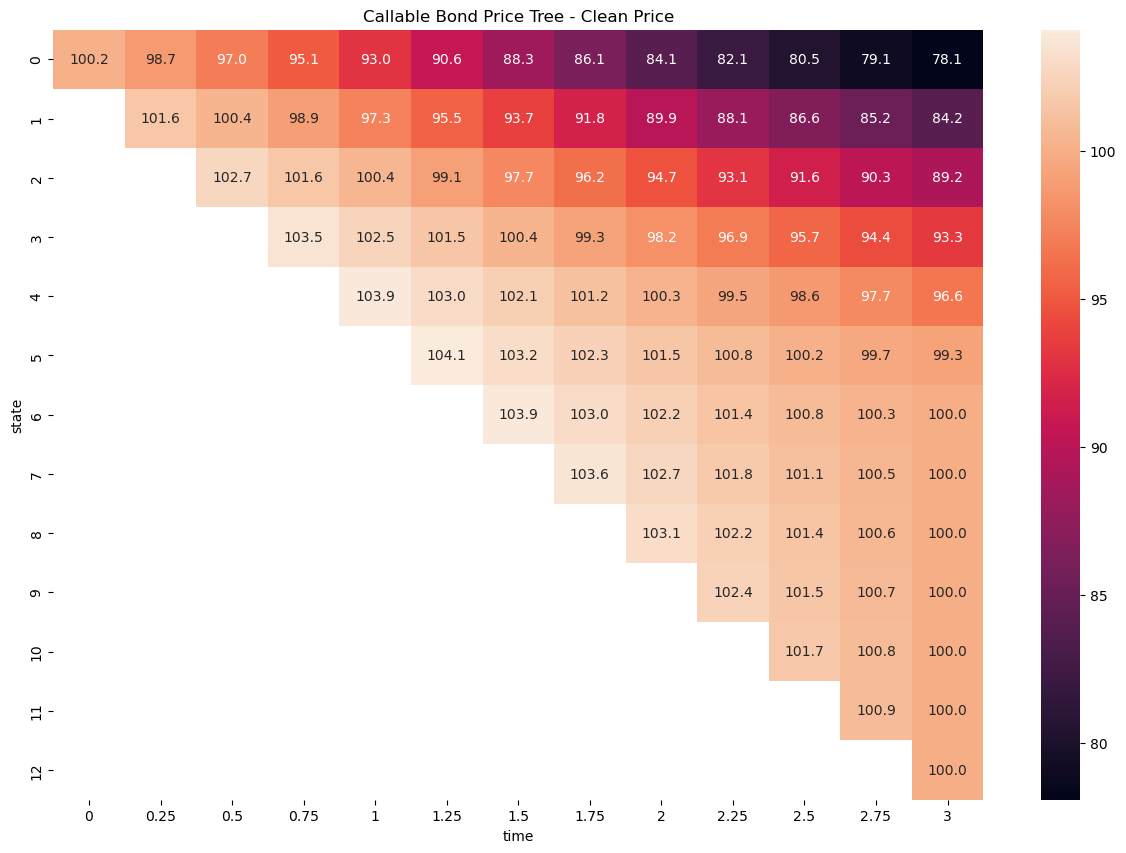

In [22]:
plt.figure(figsize=(15, 10))
plt.title('Callable Bond Price Tree - Clean Price')
sns.heatmap(callablebondtree_clean, annot=True, fmt='.1f')

<Axes: title={'center': 'Callable Bond Price Tree - Dirty Price'}, xlabel='time', ylabel='state'>

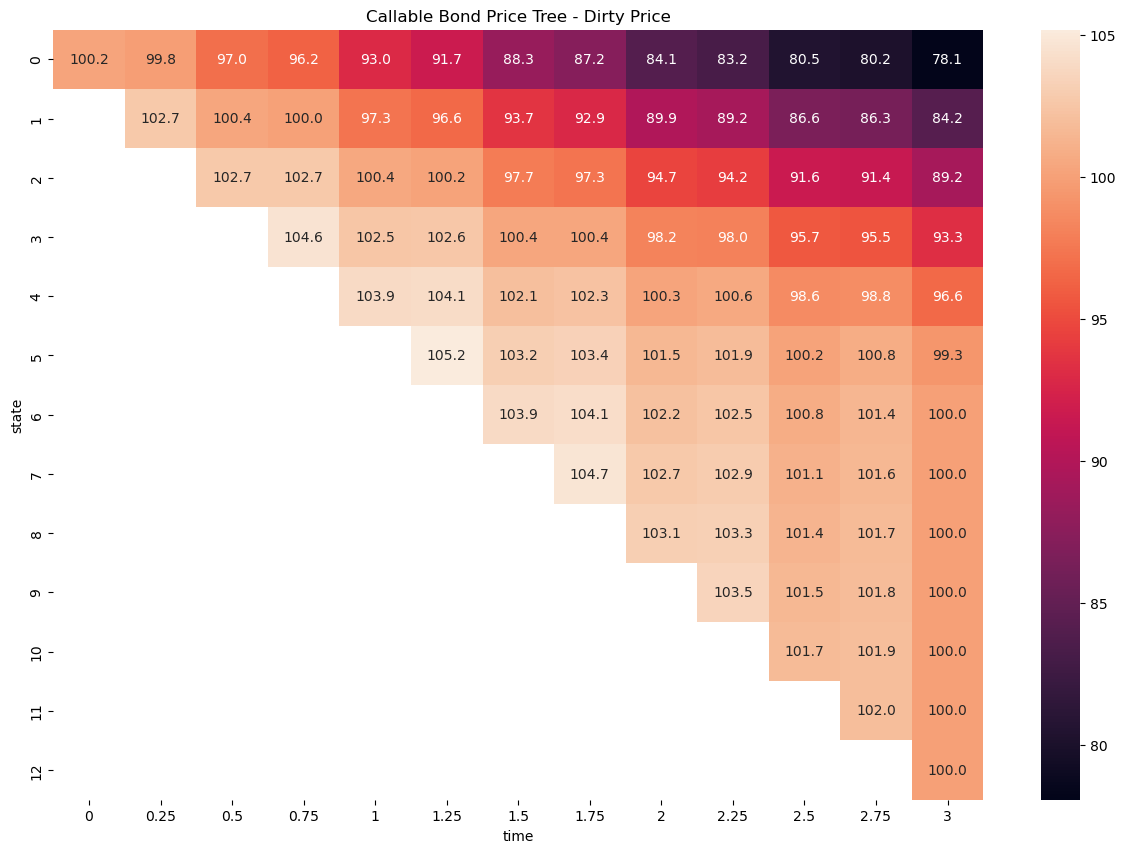

In [23]:
plt.figure(figsize=(15, 10))
plt.title('Callable Bond Price Tree - Dirty Price')
sns.heatmap(callablebondtree_dirty, annot=True, fmt='.1f')

### 2.3.

Report the initial node value of the call option and of the callable bond.

In a table, compare these to what you got in HW 1 as the value of the embedded call and the value of the callable bond.
* In `HW 1`, we were valuing from a date nearly two weeks later, `2025-02-13`. This difference in the timing means we wouldn't expect the values to match exactly, even if the methods were entirely consistent.

In [24]:
callable_bond_price = callablebondtree_clean.iloc[0,0]
call_price = calltree.iloc[0,0]
vanilla_bond_price = cleantree.iloc[0,0]
vanilla_bond_black = 101.87
call_black = 1.62
callable_bond_black = vanilla_bond_black - call_black

pd.DataFrame([[callable_bond_price, callable_bond_black], [call_price, call_black], [vanilla_bond_price, vanilla_bond_black]], index=['Callable Bond', 'Call Option', 'Vanilla Bond'], columns=['Price', 'Black Price']).style.format('{:.2f}')

,Price,Black Price
Callable Bond,100.22,100.25
Call Option,1.65,1.62
Vanilla Bond,101.87,101.87


***

# 3. Pricing the Callable - American

### 3.1.

Re-do part `2.`, but this time, make the option a **American** style. That is, allow it to be exercised at any node.
* Report the tree of callable-bond values.
* How does this compare to the European-style?

#### Note
To do this valuation, go through the procedure in `2.1.`, but at each node, compare the value for the call with the value of the payoff function based on the vanilla bond's value at that node. Take the maximum of the two. If you code this carefully, you can simply add a line of code to what you did in `2.1`.

In [29]:
calltree_american = bintree_pricing(payoff=payoff_call, ratetree=ratetree.iloc[:13,:13], undertree= cleantree.iloc[:13,:13], style='american'  )

<Axes: title={'center': 'American Call Option Price Tree'}, xlabel='time', ylabel='state'>

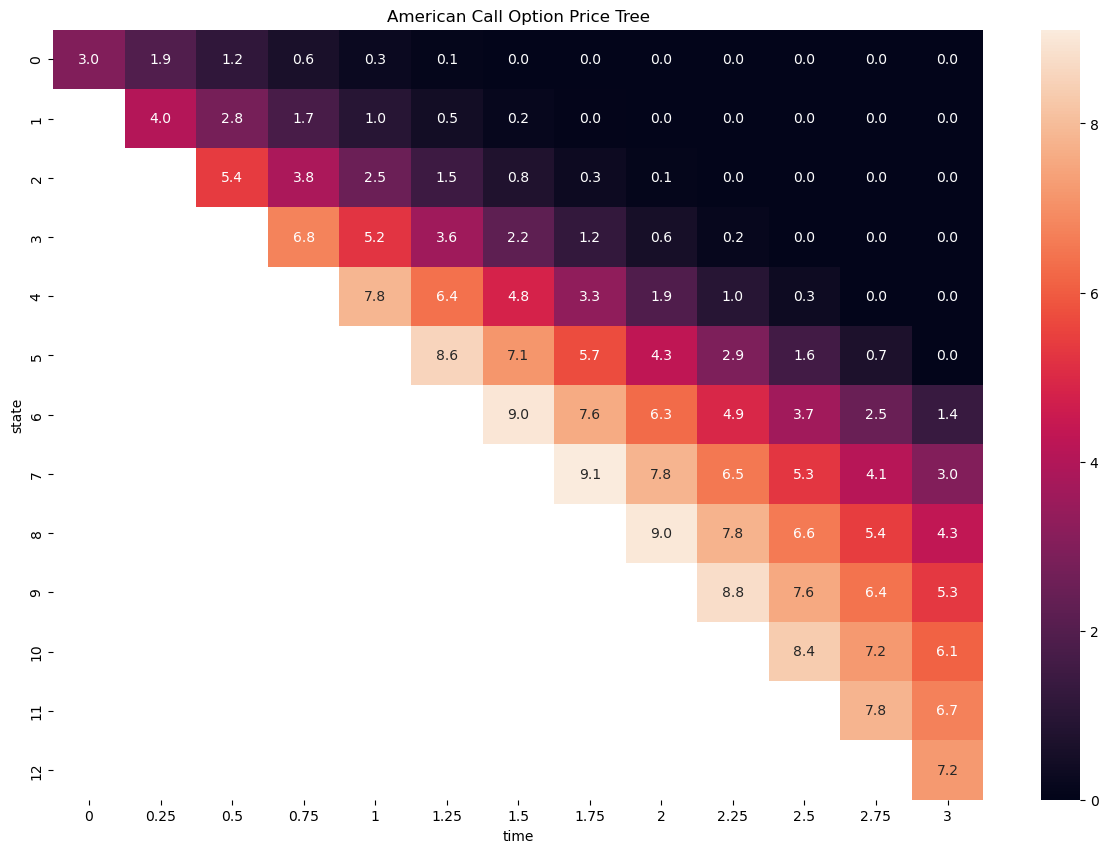

In [30]:
plt.figure(figsize=(15, 10))
plt.title('American Call Option Price Tree')
sns.heatmap(calltree_american, annot=True, fmt='.1f')

In [35]:
callablebondtree_clean_ammerican = (cleantree - calltree_american).iloc[:13,:13]
callablebondtree_dirty_ammerican =( bondtree - calltree_american).iloc[:13,:13]

<Axes: title={'center': 'Callable Bond Price Tree - Clean Price'}, xlabel='time', ylabel='state'>

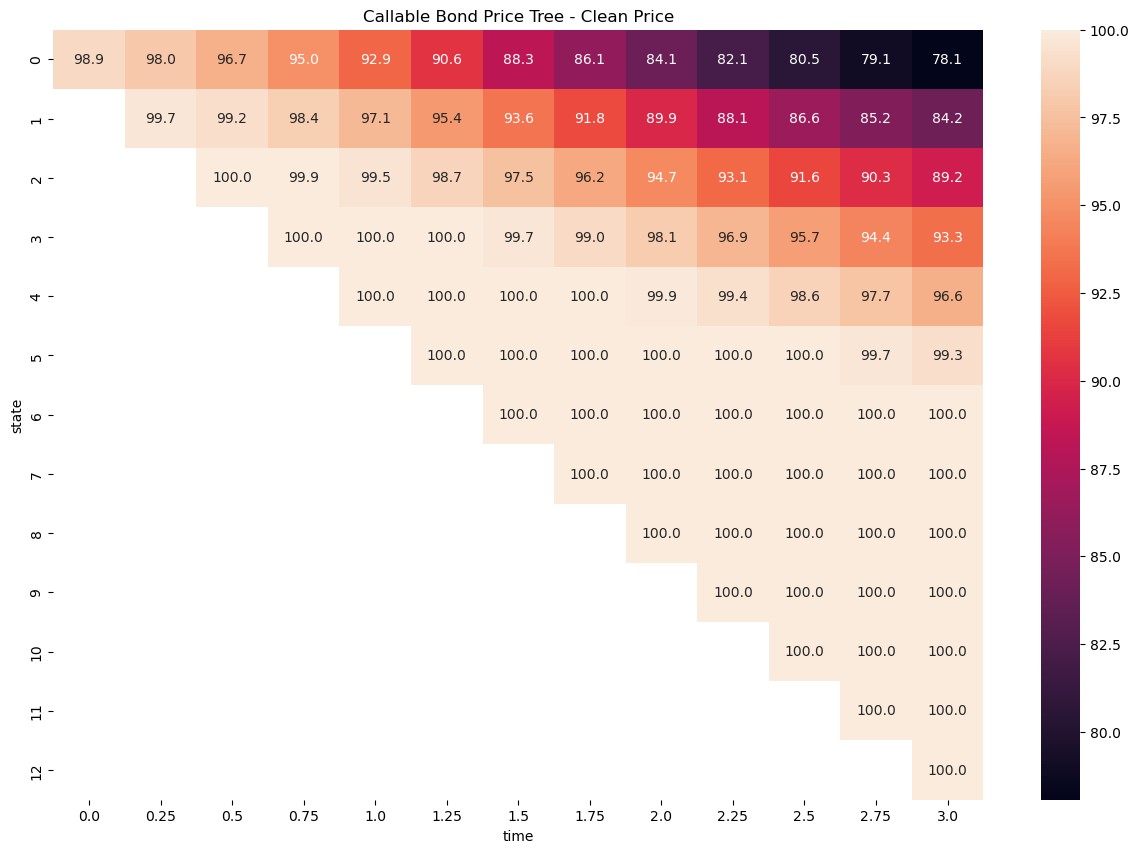

In [36]:
plt.figure(figsize=(15, 10))
plt.title('Callable Bond Price Tree - Clean Price')
sns.heatmap(callablebondtree_clean_ammerican, annot=True, fmt='.1f')

<Axes: title={'center': 'Callable Bond Price Tree - Dirty Price'}, xlabel='time', ylabel='state'>

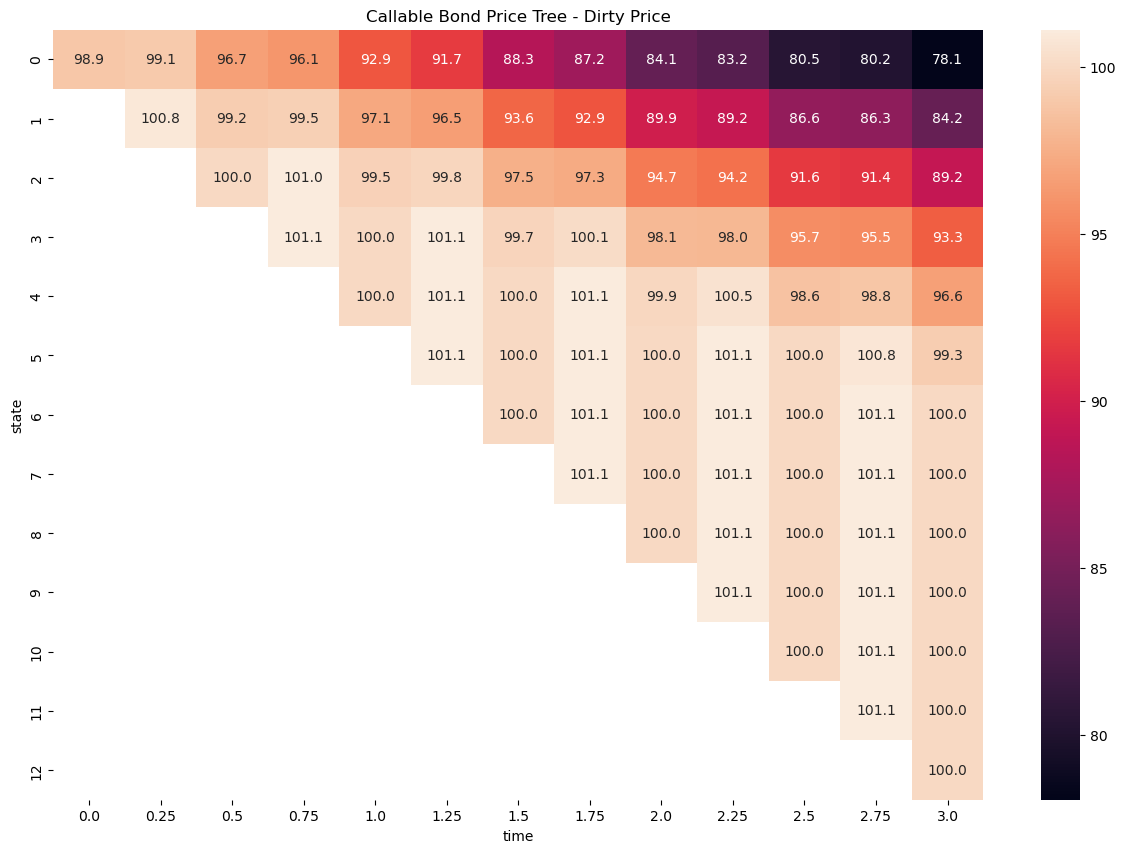

In [37]:
plt.figure(figsize=(15, 10))
plt.title('Callable Bond Price Tree - Dirty Price')
sns.heatmap(callablebondtree_dirty_ammerican, annot=True, fmt='.1f')

In [38]:
call_amercian_price = calltree_american.iloc[0,0]
callable_bond_price_american = callablebondtree_clean_ammerican.iloc[0,0]

pd.DataFrame([[callable_bond_price_american, callable_bond_price], [call_amercian_price, call_price]], index=['Callable Bond', 'Call Option'], columns=['American', 'European']).style.format('{:.2f}')

,American,European
Callable Bond,98.91,100.22
Call Option,2.96,1.65


### 3.2.

In which nodes will the American-style callable bond be exercised?

In [42]:
temp_ITM = cleantree.iloc[:13,:13] > STRIKE
temp_exer = exercise_decisions(payoff_call,cleantree.iloc[:13,:13],calltree_american)
temp = (1*temp_ITM+temp_exer*2).where(calltree_american.notna(), np.nan)

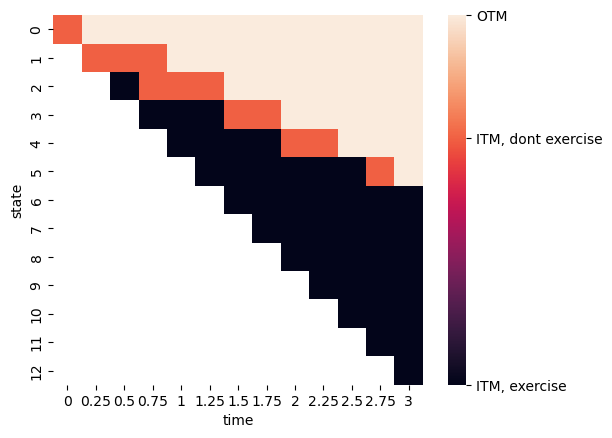

In [43]:
ax = sns.heatmap(-temp,square=True);

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-3, -1, 0])  
colorbar.set_ticklabels(['ITM, exercise', 'ITM, dont exercise', 'OTM'])  
plt.show()

***

# 4. Pricing the Callable - Bermudan

#### This Section is NOT REQUIRED and NOT EXPECTED
Still, it is not much additional work, and some of you may find it interesting. It also illustrates the power of binomial trees in how easily they handle the Bermudan style. 

### 4.1.

Re-do part `3`, but this time with **Bermudan** style exercise. 
* This corresponds to the Freddie Mac bond in `HW 1`.
* Note that the option value tree will now go all the way to $T$.

As a reminder, the Bermudan style can be exercised as early as $T_o$ all the way to $T$. It can only be exercised on specific dates at 3-month intervals, but in our quarterly-spaced tree, this means every node from $T_o$ onward.

### 4.2.

Compare the valuation to the market quote in `HW 1`.

***